# Week 10 - Information Theory

In [2]:
print("Hello, world!")

Hello, world!


In [ ]:
import zlib  # Also lzma

text = "Here is some text some text text text with repetition"
print(f"Original text {len(text)} bytes:", text)

text_bytes = text.encode('ascii')
comp = zlib.compress(text_bytes)
print(f"Compressed text {len(comp)} bytes:", comp)

decomp = zlib.decompress(comp)
print("Decompressed text:", decomp.decode('ascii'))

ratio = len(comp) / len(text_bytes)
print(f"Compression ration: {ratio:.2f}")


Original text 53 bytes: Here is some text some text text text with repetition
Compressed text 43 bytes: b'x\x9c\xf3H-JU\xc8,V(\xce\xcfMU(I\xad(Ab!\x88\xf2\xcc\x92\x0c\x85\xa2\xd4\x82\xd4\x92\xcc\x92\xcc\xfc<\x00\x0c\x82\x13\xfc'
Decompressed text: Here is some text some text text text with repetition
Compression ration: 0.81


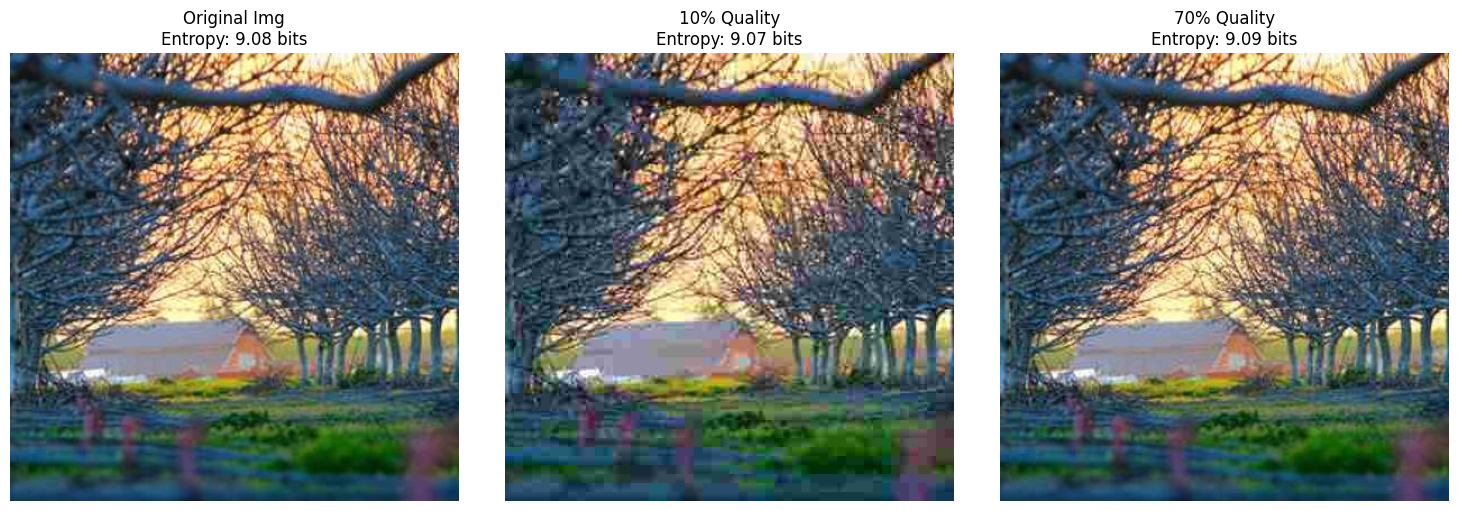

In [48]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

def entropy(img):
    histogram = img.histogram()
    probs = [float(h) / sum(histogram) for h in histogram]
    return -sum(p * np.log2(p) for p in probs if p != 0)

def compress(img, quality=75):
    fname = f'../images/q_{quality}.jpg'
    img.save(fname, 'JPEG', quality=quality)
    compressed = Image.open(fname)
    return compressed, entropy(compressed)

url       = 'https://picsum.photos/400/400'
response  = requests.get(url)
original  = Image.open(BytesIO(response.content))

qualities = [10, 70]
images    = [original]
entropies = [entropy(original)]
titles    = ['Original Img']
for q in qualities:
    img_c, img_h = compress(original, q)
    images.append(img_c)
    entropies.append(img_h)
    titles.append(f'{q}% Quality')

plt.figure(figsize=(15, 5))
for lcv, (img, ent, title) in enumerate(zip(images,entropies,titles), start=1):
    plt.subplot(1, len(images), lcv)
    plt.imshow(img)
    plt.title(f"{title}\nEntropy: {ent:.2f} bits")
    plt.axis('off')

plt.tight_layout()
plt.show()